<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/25th%20April%20Feval%20Lgbm%20Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn
from sklearn import *
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold
from sklearn.multioutput import RegressorChain


import requests
import time
from scipy import stats

import lightgbm as lgb
import xgboost as xgb

In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [3]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [4]:
cat_feature = []
for i in train.columns:
    val = train[i].value_counts()
    if val.shape[0] == 2:
        cat_feature.append(i)
cat_feature

['Feature_8', 'Feature_9', 'Feature_10', 'Feature_11']

In [5]:
all_features = [f for f in train.columns if "Feature" in f]

In [6]:
num_features = [f for f in all_features if f not in cat_feature]

In [7]:
def add_features(df):
    for f in df[num_features].columns:
        df['pos_'+str(f)] = df[f]+abs(df[f].min())+1
    for f in [f for f in df.columns if "pos" in f]:
        df['log_'+str(f[4:])] = np.log(df[str(f)])
    for f in [f for f in df.columns if "pos" in f]:
        df['sqrt_'+str(f[4:])] = np.sqrt(df[str(f)])
    df.drop(columns = [f for f in df.columns if "pos" in f], inplace=True)
    return df

In [8]:
train = add_features(train)
test = add_features(test)

In [61]:
ocorr = (train.corrwith(target.target_r).abs() + train.corrwith(target.target_g).abs() + train.corrwith(target.target_b).abs() )/3
ocorr.sort_values(ascending=False)

log_Feature_4      0.134832
sqrt_Feature_4     0.133752
Feature_4          0.132467
log_Feature_14     0.121922
sqrt_Feature_14    0.121341
Feature_14         0.120519
Feature_13         0.073641
Feature_12         0.070392
sqrt_Feature_13    0.069210
sqrt_Feature_12    0.068702
log_Feature_12     0.066918
log_Feature_13     0.064614
Feature_10         0.059475
Feature_11         0.052461
Feature_9          0.045778
log_Feature_6      0.043051
sqrt_Feature_6     0.042681
Feature_6          0.042187
Feature_1          0.032297
sqrt_Feature_1     0.030877
log_Feature_1      0.029371
Feature_2          0.028854
sqrt_Feature_2     0.027374
log_Feature_2      0.025810
Feature_8          0.025185
Feature_5          0.021458
sqrt_Feature_5     0.021145
Feature_7          0.020798
log_Feature_5      0.020783
sqrt_Feature_7     0.020287
log_Feature_7      0.019730
log_Feature_3      0.012204
sqrt_Feature_3     0.011257
Feature_3          0.010237
dtype: float64

In [10]:
df = train.copy(deep=True)

In [11]:
sqrt_feature = [f for f in df.columns if "sqrt" in f]
log_feature= [f for f in df.columns if "log" in f]
sqrt_log_feature = sqrt_feature + log_feature

In [59]:
# power_corr = []
# df = pd.DataFrame()
# for i in np.linspace(2, 20, 50):
#     print(i)
#     for f in sqrt_log_feature:
#         print(f)
#         df[f'power_{i}' +str(f)] = np.power(train[f], i)
#     c_r = df.corrwith(target.target_r).abs()
#     c_g = df.corrwith(target.target_g).abs()
#     c_b = df.corrwith(target.target_b).abs()
#     power_corr.append((c_r + c_g + c_b)/3)
# pd.concat(power_corr).sort_values(ascending=False)

In [148]:
from sklearn.preprocessing import PolynomialFeatures
def polynomial_features(df):

    poly = PolynomialFeatures(degree=4, interaction_only=True,include_bias=False)
    sqrt_feature = [f for f in df.columns if "sqrt" in f]
    log_feature= [f for f in df.columns if "log" in f]
    sqrt_log_feature = sqrt_feature + log_feature
    emb = poly.fit_transform(df[sqrt_log_feature].values)
    poly_df = pd.DataFrame(emb, columns=[f'poly_{i}' for i in  range(emb.shape[1]) ])
    concat_df = pd.concat([df, poly_df], axis=1)
    return concat_df

In [149]:
train_df = polynomial_features(train)
test_df = polynomial_features(test)

In [151]:
corr_r = train_df.corrwith(target.target_r).abs()
corr_g = train_df.corrwith(target.target_g).abs()
corr_b = train_df.corrwith(target.target_b).abs()
overall_corr = (corr_r + corr_g + corr_b)/3
overall_corr.sort_values(ascending=False, inplace=True)
corr_feat = overall_corr[overall_corr > 0.135].index.tolist()

In [ ]:
!pip install optuna

In [105]:
def spearman_r(preds, dtrain):
    labels = dtrain.get_label()
    score = stats.spearmanr(labels, preds)[0]
    return 'spearman_r', score, True
def spearman_g(preds, dtrain):
    labels = dtrain.get_label()
    score = stats.spearmanr(labels, preds)[0]
    return 'spearman_g', score, True
def spearman_b(preds, dtrain):
    labels = dtrain.get_label()
    score = stats.spearmanr(labels, preds)[0]
    return 'spearman_b', score, True

In [113]:
%%time
import optuna
kf = KFold(n_splits=5, random_state=60)
X =  train
y = target

N_TRIALS = 200
def objective(trial):    
    
    params = {
    'num_leaves': trial.suggest_int('num_leaves', 4, 64),
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'custom',
    'max_depth': trial.suggest_int('max_depth', 4, 16),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
    'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
    'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
    'max_bin': trial.suggest_int('max_bin', 50, 900),
    'early_stopping_rounds': 100, 
    }


    oof_pred_r = np.zeros(len(X))
    oof_pred_g = np.zeros(len(X))
    oof_pred_b = np.zeros(len(X))
    kf = KFold(n_splits=3, random_state=60)
    
    cnt = 1
    for tr_ind , val_ind in kf.split(X, y):
        # print(f'Fold:{cnt}, Train set: {len(tr_ind)}, Test set:{len(val_ind)}') 
        
        X_train, X_val = X.iloc[tr_ind], X.iloc[val_ind]
        y_train, y_val = y.iloc[tr_ind], y.iloc[val_ind]

        tr_data_r = lgb.Dataset(X_train, y_train.target_r)
        va_data_r = lgb.Dataset(X_val, y_val.target_r)

        tr_data_g = lgb.Dataset(X_train, y_train.target_g)
        va_data_g = lgb.Dataset(X_val, y_val.target_g)

        tr_data_b = lgb.Dataset(X_train, y_train.target_b)
        va_data_b = lgb.Dataset(X_val, y_val.target_b)
        
        model_r = lgb.train(params, tr_data_r, valid_sets=[tr_data_r, va_data_r], verbose_eval=None, num_boost_round=5000, 
                            early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_r)
        # print(model_r)
        model_g = lgb.train(params, tr_data_g, valid_sets=[tr_data_g, va_data_g], verbose_eval=None, num_boost_round=5000, 
                            early_stopping_rounds=100, categorical_feature=cat_feature, feval= spearman_g)
        # print(model_g)
        model_b = lgb.train(params, tr_data_b, valid_sets=[tr_data_b, va_data_b], verbose_eval=None, num_boost_round=5000, 
                            early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_b)
        # print(model_b)
        # print(" ")

        val_pred_r = model_r.predict(X_val)
        val_pred_g = model_g.predict(X_val)
        val_pred_b = model_b.predict(X_val)

        oof_pred_r[val_ind] = val_pred_r
        oof_pred_g[val_ind] = val_pred_g
        oof_pred_b[val_ind] = val_pred_b


        cnt += 1
    oof_pred_df = pd.concat([pd.DataFrame(oof_pred_r, columns=['target_r']),
                        pd.DataFrame(oof_pred_g, columns=['target_g']),
                        pd.DataFrame(oof_pred_b, columns=['target_b'])], axis=1)

    # display(oof_pred_df)
    score_r = stats.spearmanr(oof_pred_df.target_r, target.target_r)[0]
    score_g = stats.spearmanr(oof_pred_df.target_g, target.target_g)[0]
    score_b = stats.spearmanr(oof_pred_df.target_b, target.target_b)[0]

    score = (score_r+score_g+score_b)/ 3
    from google.colab import output
    output.clear()
    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)
display(study.best_params)
display(study.best_trial.value)

[I 2021-04-25 16:49:53,509] Trial 199 finished with value: 0.11461719900779348 and parameters: {'num_leaves': 11, 'max_depth': 9, 'min_child_weight': 3, 'feature_fraction': 0.416617262195194, 'bagging_fraction': 0.9287666811742312, 'bagging_freq': 2, 'min_child_samples': 39, 'lambda_l1': 0.3067546040791782, 'lambda_l2': 0.09467496144934039, 'learning_rate': 0.762111216117457, 'max_bin': 502}. Best is trial 139 with value: 0.14563170171397788.



{'bagging_fraction': 0.8768723852153937,
 'bagging_freq': 2,
 'feature_fraction': 0.4316657803439479,
 'lambda_l1': 2.9918794057800284e-05,
 'lambda_l2': 0.013354439316086594,
 'learning_rate': 0.8576187736126148,
 'max_bin': 513,
 'max_depth': 6,
 'min_child_samples': 80,
 'min_child_weight': 8,
 'num_leaves': 9}

0.14563170171397788

CPU times: user 55min 25s, sys: 16.6 s, total: 55min 42s
Wall time: 28min 22s


In [116]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'custom',
    'bagging_fraction': 0.8768723852153937,
 'bagging_freq': 2,
 'feature_fraction': 0.4316657803439479,
 'lambda_l1': 2.9918794057800284e-05,
 'lambda_l2': 0.013354439316086594,
 'learning_rate': 0.8576187736126148,
 'max_bin': 513,
 'max_depth': 6,
 'min_child_samples': 80,
 'min_child_weight': 8,
 'num_leaves': 9}

X =  train
y = target

original_test_preds_r = np.zeros(len(test))
original_test_preds_g = np.zeros(len(test))
original_test_preds_b = np.zeros(len(test))


kf = KFold(n_splits=5, random_state=60)

cnt = 1
for tr_ind , val_ind in kf.split(X, y):
    # print(f'Fold:{cnt}, Train set: {len(tr_ind)}, Test set:{len(val_ind)}') 
    
    X_train, X_val = X.iloc[tr_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[tr_ind], y.iloc[val_ind]

    tr_data_r = lgb.Dataset(X_train, y_train.target_r)
    va_data_r = lgb.Dataset(X_val, y_val.target_r)

    tr_data_g = lgb.Dataset(X_train, y_train.target_g)
    va_data_g = lgb.Dataset(X_val, y_val.target_g)

    tr_data_b = lgb.Dataset(X_train, y_train.target_b)
    va_data_b = lgb.Dataset(X_val, y_val.target_b)
    
    model_r = lgb.train(params, tr_data_r, valid_sets=[tr_data_r, va_data_r], verbose_eval=100, num_boost_round=5000, 
                        early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_r)
    # print(model_r)
    model_g = lgb.train(params, tr_data_g, valid_sets=[tr_data_g, va_data_g], verbose_eval=100, num_boost_round=5000, 
                        early_stopping_rounds=100, categorical_feature=cat_feature, feval= spearman_g)
    # print(model_g)
    model_b = lgb.train(params, tr_data_b, valid_sets=[tr_data_b, va_data_b], verbose_eval=100, num_boost_round=5000, 
                        early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_b)


    original_test_preds_r += model_r.predict(test)
    original_test_preds_g += model_g.predict(test)
    original_test_preds_b += model_b.predict(test)

original_test_preds_r = original_test_preds_r / kf.n_splits
original_test_preds_g = original_test_preds_g / kf.n_splits
original_test_preds_b = original_test_preds_b / kf.n_splits

Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_r: 0.546264	valid_1's spearman_r: 0.0179416
Early stopping, best iteration is:
[5]	training's spearman_r: 0.28529	valid_1's spearman_r: 0.0518272
Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_g: 0.600691	valid_1's spearman_g: 0.15066
[200]	training's spearman_g: 0.665422	valid_1's spearman_g: 0.157147
Early stopping, best iteration is:
[157]	training's spearman_g: 0.642341	valid_1's spearman_g: 0.168814
Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_b: 0.631063	valid_1's spearman_b: 0.290454
Early stopping, best iteration is:
[6]	training's spearman_b: 0.378455	valid_1's spearman_b: 0.334591
Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_r: 0.51718	valid_1's spearman_r: 0.120866
Early stopping, best iteration is:
[34]	training's spearman_r: 0.414631	valid_1's spearman_r: 0.

In [120]:
 prediction = pd.concat([pd.DataFrame(original_test_preds_r, columns=['target_r']),
                    pd.DataFrame(original_test_preds_g, columns=['target_g']),
                    pd.DataFrame(original_test_preds_b, columns=['target_b'])], axis=1)

In [126]:
# prediction[prediction['target_g'] > 1]
for i in prediction.columns:
    print(prediction[i].nunique())

7469
8106
8106


In [124]:
prediction.describe()

,target_r,target_g,target_b
count,12910.000000,12910.000000,12910.000000
mean,0.553952,0.596725,0.536083
std,0.075406,0.162210,0.139080
min,0.240885,0.036480,0.025182
25%,0.508818,0.494754,0.455312
50%,0.566549,0.620659,0.548177
75%,0.606020,0.715685,0.626146
max,0.768622,1.151043,0.957670


In [130]:
np.random.random(1)

array([0.38852405])

In [132]:
prediction[prediction['target_g'] > 1] = 1

In [141]:
prediction[prediction['target_b'] == 1] == prediction[prediction['target_r'] == 1]

,target_r,target_g,target_b
2836,True,True,True
8924,True,True,True
8973,True,True,True
9284,True,True,True
10427,True,True,True
11415,True,True,True
11417,True,True,True
11419,True,True,True
11420,True,True,True
11421,True,True,True


In [142]:
prediction[prediction['target_r'] == 1] == prediction[prediction['target_g'] == 1]

,target_r,target_g,target_b
2836,True,True,True
8924,True,True,True
8973,True,True,True
9284,True,True,True
10427,True,True,True
11415,True,True,True
11417,True,True,True
11419,True,True,True
11420,True,True,True
11421,True,True,True


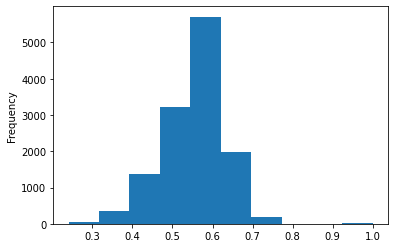

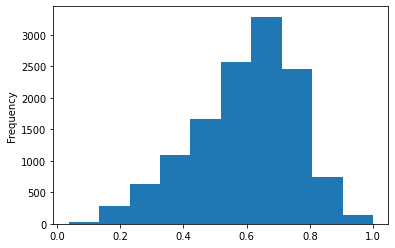

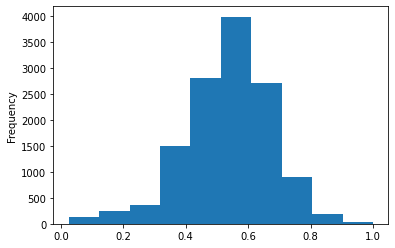

In [143]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [144]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

ERR: Too many submissions
